In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS
import wrds

# Data

In [2]:
raw = pd.read_excel("../data/raw_1203.xlsx")
raw.head()

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,Company Name,...,Long-Term Debt - Total,Short-Term Investments- Total,Current Liabilities - Total,Net Income (Loss),Preferred Stock At Carrying Value - Utility,Capital Expenditures,Net Income (Loss).1,Operating Activities - Net Cash Flow,Active/Inactive Status Marker,Standard Industry Classification Code
0,1045,1970-03-31,1970,1.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,-4.409,NaN,NaN,-4.409,NaN,A,4512
1,1045,1970-06-30,1970,2.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,2.708,NaN,NaN,NaN,NaN,A,4512
2,1045,1970-09-30,1970,3.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,2.788,NaN,NaN,NaN,NaN,A,4512
3,1045,1970-12-31,1970,4.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,713.07,NaN,NaN,-27.485,NaN,NaN,NaN,NaN,A,4512
4,1045,1971-03-31,1971,1.0,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,...,NaN,NaN,NaN,-24.257,NaN,NaN,-24.257,NaN,A,4512


In [3]:
raw.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Industry Format',
       'Level of Consolidation - Company Interim Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'Company Name',
       'ISO Currency Code', 'Calendar Data Year and Quarter',
       'Fiscal Data Year and Quarter', 'Assets - Total',
       'Common/Ordinary Equity - Total', 'Cash and Short-Term Investments',
       'Cash', 'Debt in Current Liabilities', 'Long-Term Debt - Total',
       'Short-Term Investments- Total', 'Current Liabilities - Total',
       'Net Income (Loss)', 'Preferred Stock At Carrying Value - Utility',
       'Capital Expenditures', 'Net Income (Loss).1',
       'Operating Activities - Net Cash Flow', 'Active/Inactive Status Marker',
       'Standard Industry Classification Code'],
      dtype='object')

In [4]:
raw[["Fiscal Year", "Capital Expenditures"]]

,Fiscal Year,Capital Expenditures
0,1970,NaN
1,1970,NaN
2,1970,NaN
3,1970,NaN
4,1971,NaN
...,...,...
177824,2021,60.8
177825,2021,85.1
177826,2022,25.9
177827,2022,52.9


## cal free cash flow

In [16]:
# for companies which do not have Capital Expenditures: nan --> 0

raw["FCF"] = raw['Operating Activities - Net Cash Flow'] - \
    raw['Capital Expenditures']

raw['Capital Expenditures'] = raw['Capital Expenditures'].fillna(0)
raw["FCF_fillna"] = raw['Operating Activities - Net Cash Flow'] - \
    raw['Capital Expenditures']
raw["FCF_diff"] = raw["FCF_fillna"].diff()
raw["FCF_annualized"] = raw["FCF_fillna"]*4

## cal invested capital

In [7]:
def fillna(df, col_name):
    df[col_name] = df[col_name].fillna(0)
    return df


raw = fillna(raw, "Debt in Current Liabilities")
raw = fillna(raw, "Long-Term Debt - Total")
raw = fillna(raw, 'Common/Ordinary Equity - Total')
raw = fillna(raw, 'Preferred Stock At Carrying Value - Utility')
raw = fillna(raw, 'Cash and Short-Term Investments')

In [8]:
raw["IC_cal"] = raw["Debt in Current Liabilities"] + \
    raw["Long-Term Debt - Total"] + raw['Common/Ordinary Equity - Total'] + raw["Preferred Stock At Carrying Value - Utility"]- \
    raw['Cash and Short-Term Investments']

In [9]:
raw["IC_cal"] = raw["IC_cal"].replace(0.0, np.nan)

In [10]:
raw["IC_cal"]

0              NaN
1              NaN
2              NaN
3         1111.263
4              NaN
            ...   
177824    2652.500
177825    2583.800
177826    2593.700
177827    2665.100
177828    2662.000
Name: IC_cal, Length: 177829, dtype: float64

<AxesSubplot: >

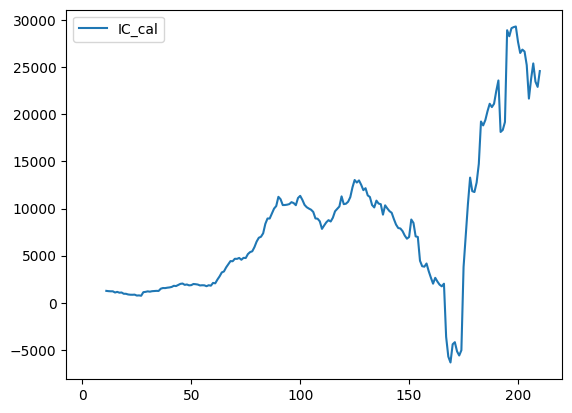

In [11]:
raw[raw["Ticker Symbol"] == "AAL"][["IC_cal"]].plot()

In [17]:
raw["pre_IC_cal"] = raw["IC_cal"].shift()
raw["avg_IC_cal"] = (raw["IC_cal"] + raw["pre_IC_cal"])/2
raw["avg_IC_cal"] = raw["avg_IC_cal"].replace(0.0, np.nan)

raw["FCFROIC_cal"] = raw["FCF_annualized"]/raw["avg_IC_cal"]  # 3

## cal financial industry roe

In [13]:
# for those finance service companies
raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
                     raw["Stockholders Equity - Total"].shift()) * 1/2
raw["ave_asset"] = (raw['Assets - Total'] +
                    raw['Assets - Total'].shift()) * 1/2

# raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
# raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
#                                                 == 1]["Net Income (Loss)"]

# #####################################
# raw["NI_chg"] = raw["NI_chg"]
raw["ROA"] = raw["Net Income (Loss)"]/raw["ave_asset"]
raw["ROE"] = raw["Net Income (Loss)"]/raw["ave_equity"]


KeyError: 'Stockholders Equity - Total'

In [ ]:
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
raw["FCFROIC_ADJ"] = raw["FCFROIC_cal"].copy()
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC_ADJ"] = raw.loc[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]

In [ ]:
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)]

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,Company Name,...,IC_cal,pre_IC_cal,avg_IC_cal,FCFROIC_cal,ave_equity,ave_asset,ROA,ROE,SIC,FCFROIC_ADJ
907,1177,1971-03-31,1971,1.0,INDL,C,D,STD,AET,AETNA INC,...,164.895,536.000,350.4475,NaN,0.0,NaN,NaN,inf,6324,inf
908,1177,1971-06-30,1971,2.0,INDL,C,D,STD,AET,AETNA INC,...,224.323,164.895,194.6090,NaN,0.0,NaN,NaN,inf,6324,inf
909,1177,1971-09-30,1971,3.0,INDL,C,D,STD,AET,AETNA INC,...,228.523,224.323,226.4230,NaN,0.0,NaN,NaN,inf,6324,inf
910,1177,1971-12-31,1971,4.0,INDL,C,D,STD,AET,AETNA INC,...,160.042,228.523,194.2825,NaN,0.0,NaN,NaN,inf,6324,inf
911,1177,1972-03-31,1972,1.0,INDL,C,D,STD,AET,AETNA INC,...,227.428,160.042,193.7350,NaN,0.0,NaN,NaN,inf,6324,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177770,318728,2021-09-30,2021,3.0,INDL,C,D,STD,ATH,ATHENE HOLDING LTD,...,11807.000,11144.000,11475.5000,0.632739,22021.5,219972.5,0.003332,0.033286,6311,0.033286
177771,318728,2021-12-31,2021,4.0,INDL,C,D,STD,ATH,ATHENE HOLDING LTD,...,12882.000,11807.000,12344.5000,0.833732,22276.5,229772.5,0.004766,0.049155,6311,0.049155
177772,318728,2022-03-31,2022,1.0,INDL,C,D,STD,ATH,ATHENE HOLDING LTD,...,13589.000,12882.000,13235.5000,0.011711,17936.5,240641.5,-0.006163,-0.082681,6311,-0.082681
177773,318728,2022-06-30,2022,2.0,INDL,C,D,STD,ATH,ATHENE HOLDING LTD,...,-5545.000,13589.000,4022.0000,1.175037,8540.5,240194.0,-0.008826,-0.248229,6311,-0.248229


# functions

In [ ]:
def rmv_outliner(data, method="3sigma", lo_q=0.01, hi_q=0.99, fill="delete"):
    '''
    remove outliner
    '''
    if method == "3sigma":
        _h = data.mean() + 3*data.std()
        _l = data.mean() - 3*data.std()
    elif method == "quantile":
        q = data.quantile([lo_q, hi_q])
        _l = q.iloc[0]
        _h = q.iloc[1]

    if fill == "delete":
        for colname in data.columns:
            data = data.copy()
            data = data[(data[colname] < _h[colname]) &
                        (data[colname] > _l[colname])]

    return data

# Calculation

In [ ]:
# # average invested capital
# raw["pre_IC"] = raw["Invested Capital - Total - Quarterly"].shift()
# raw["ave_IC"] = (
#     raw["Invested Capital - Total - Quarterly"] + raw["pre_IC"]) * 1/2
# raw["IC_diff"] = raw["Invested Capital - Total - Quarterly"] - raw["pre_IC"]

# # for companies which do not have Capital Expenditures: nan --> 0
# # raw[raw['Capital Expenditures'] == np.nan] = 0
# raw["FCF"] = raw['Operating Activities - Net Cash Flow'] - \
#     raw['Capital Expenditures']

# raw['Capital Expenditures'] = raw['Capital Expenditures'].fillna(0)
# raw["FCF_fillna"] = raw['Operating Activities - Net Cash Flow'] - \
#     raw['Capital Expenditures']

# raw["FCFROIC"] = raw["FCF"]/raw["ave_IC"]  ## 1
# raw["FCFROIC_fillna"] = raw["FCF_fillna"]/raw["ave_IC"]  ## 2
# # Common/Ordinary Equity - Total
# # Investment and Advances - Equity
# raw["IC_cal"] = raw["Current Liabilities - Total"] + raw["Long-Term Debt - Total"] - raw["Cash"]
     
# raw["pre_IC_cal"] = raw["IC_cal"].shift()
# raw["avg_IC_cal"] = (raw["IC_cal"] + raw["pre_IC_cal"])/2

# raw["FCFROIC_cal"] = raw["FCF_fillna"]/raw["avg_IC_cal"]  # 3

# # for those finance service companies
# raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
#                      raw["Stockholders Equity - Total"].shift()) * 1/2
# raw["ave_asset"] = (raw['Assets - Total'] +
#                     raw['Assets - Total'].shift()) * 1/2

# raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
# raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
#                                                 == 1]["Net Income (Loss)"]

# #####################################
# raw["NI_chg"] = raw["NI_chg"]
# raw["ROA"] = raw["NI_chg"]/raw["ave_asset"]
# raw["ROE"] = raw["NI_chg"]/raw["ave_equity"]

In [ ]:
# # finance industry: SIC code 6000-6411
# raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
# raw["FCFROIC_ADJ"] = raw["FCFROIC_cal"].copy()
# raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC_ADJ"] = raw.loc[(
#     raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]

In [18]:
grouped = raw.groupby('Global Company Key')
FCFROIC_ADJ = pd.DataFrame(columns=["Global Company Key", "Data Date",
                                    "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC",
                                    "ROA", "ROE", "FCFROIC_cal", "avg_fcfroic", "avg_fcfroic_expanding"])
ls = []
for group in grouped:
    group = group[1].iloc[1:][["Global Company Key", "Data Date",
                               "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC_cal"]].copy()
    group["avg_fcfroic"] = group[["FCFROIC_cal"]].rolling(
        40).mean().fillna(method="ffill")
    group["avg_fcfroic_expanding"] = group[["FCFROIC_cal"]].expanding(
        40).mean().fillna(method="ffill")
    ls.append(group)
    # FCFROIC_ADJ = FCFROIC_ADJ.append(group, ignore_index=True)
FCFROIC_ADJ = pd.concat(ls, ignore_index=True)

In [19]:
FCFROIC_ADJ[["avg_fcfroic", "avg_fcfroic_expanding"]].describe()

,avg_fcfroic,avg_fcfroic_expanding
count,74473.000000,76416.000000
mean,0.412325,0.428265
std,6.663864,8.866232
min,-62.357534,-50.796584
25%,0.013408,-0.027733
50%,0.164660,0.133449
75%,0.341726,0.297822
max,477.832886,477.690119


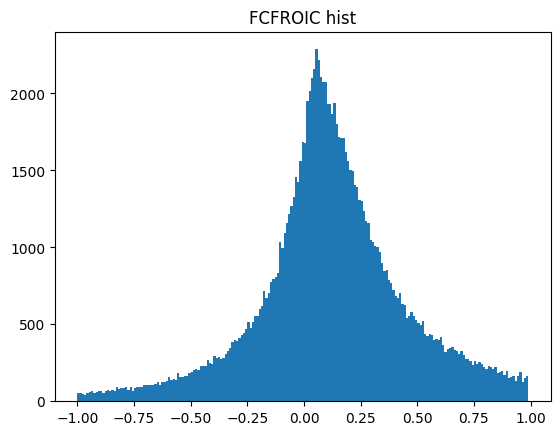

In [20]:
num = FCFROIC_ADJ["FCFROIC_cal"]
plt.hist(num, bins=np.arange(-1, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

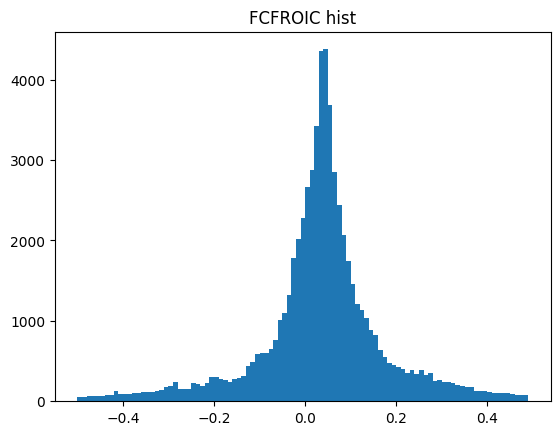

In [ ]:
num = FCFROIC_ADJ["avg_fcfroic"]
plt.hist(num, bins=np.arange(-0.5, 0.5, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/10y average FCFROIC hist.png")
plt.show()

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_178/3819934405.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  his_mean = FCFROIC_ADJ.groupby("Data Date").mean()


<AxesSubplot: xlabel='Data Date'>

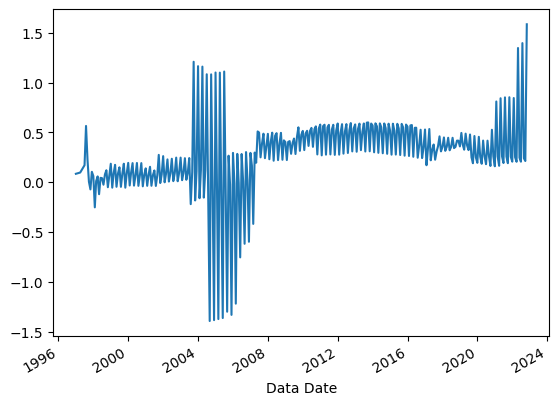

In [22]:
his_mean = FCFROIC_ADJ.groupby("Data Date").mean()
his_mean["avg_fcfroic"].dropna().plot()

<AxesSubplot: xlabel='Data Date'>

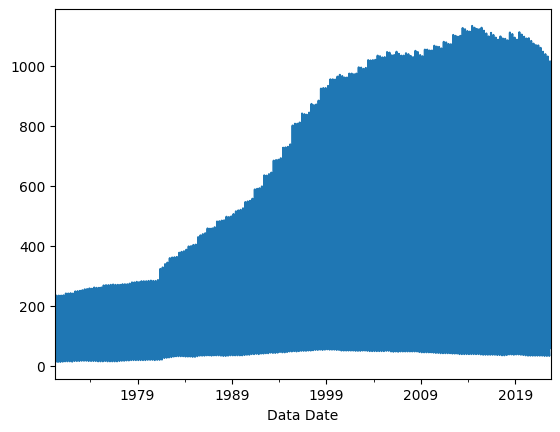

In [ ]:
his_num = FCFROIC_ADJ.groupby("Data Date").count()
his_num["Global Company Key"].dropna().plot()

In [21]:
FCFROIC_ADJ.to_excel("../clean_data/FCFROIC_ADJ_1202.xlsx")

In [ ]:
FCFROIC_ADJ

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC_cal,avg_fcfroic,avg_fcfroic_expanding
0,1045,1970-06-30,1970,2.0,AAL,NaN,NaN,NaN
1,1045,1970-09-30,1970,3.0,AAL,NaN,NaN,NaN
2,1045,1970-12-31,1970,4.0,AAL,NaN,NaN,NaN
3,1045,1971-03-31,1971,1.0,AAL,NaN,NaN,NaN
4,1045,1971-06-30,1971,2.0,AAL,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
176166,328795,2021-09-30,2021,3.0,ACA,0.006215,NaN,NaN
176167,328795,2021-12-31,2021,4.0,ACA,0.031091,NaN,NaN
176168,328795,2022-03-31,2022,1.0,ACA,-0.000541,NaN,NaN
176169,328795,2022-06-30,2022,2.0,ACA,0.022172,NaN,NaN
